In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize # word tokenizer, used to split up sentence in words
from tqdm import tqdm # TQDM Progress Bar (optional, but make sure to remove references in code)

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Data Preprocessor Cell for CNN

# Set the variable below to `True`  to reload and save processed data to file.
# Set the variable below to `False` to load processed data from file.
REBUILD_DATA = False

class DataPreprocessor():
    TRAINING_DATA = "train.csv"
    COLS_INCLUDE = {"comment_text": "object", "target": "float64"}
    
    # Leave these to 0, they are set automatically:
    toxiccnt = 0
    nontoxiccnt = 0
    
    SENTENCE_LENGTH = 50    # This is the length of all sentences in the training_data.
                            # Shorter sentences will be padded to this length, while
                            # Longer sentences will be truncated
    
    EMBEDDING_DIM = 50      # Specificy which glove embeddings to use by their dimensionality
    
    word2embedding = {} # gives you the glove embedding for a word
    embedding_dim = 0 # dimension of glove embeddings. this value will be automatically set!
    
    balanced_dataset = []
    training_data = []
    
    def make_balanced_dataset(self):
        print("Building balanced dataset...")
        
        # Set up which columns to read from csv file
        dtypes = self.COLS_INCLUDE
        headers = []
        for key in dtypes:
            headers.append(key)
        
        # Read csv file
        df = pd.read_csv(self.TRAINING_DATA, header=0, usecols=headers, dtype=dtypes)
        
        # Create 2 DataFrames for toxic and non-toxic comments.
        toxic_df = df[df.target > 0.5]
        nontoxic_df = df[df.target <= 0.5]
        
        # Calculate number of toxic and non-toxic comments.
        toxiccnt = toxic_df.target.count().astype(int)
        nontoxiccnt = nontoxic_df.target.count().astype(int)
        totalcnt = toxiccnt + nontoxiccnt
        print("Dataset Statistics:")
        print("  - Number total comments:     ", totalcnt)
        print("  - Number toxic comments:     ", toxiccnt)
        print("  - Number non-toxic comments: ", nontoxiccnt)
        
        # Get the desired number of toxic and nontoxic comments
        desired_cnt = min(toxiccnt, nontoxiccnt)
        
        # Pick 'desired_cnt' number of random toxic and nontoxic comments
        print("Balancing dataset...")
        toxic_comments = toxic_df.loc[np.random.choice(toxic_df.index.values, desired_cnt)].to_numpy()
        nontoxic_comments = nontoxic_df.loc[np.random.choice(nontoxic_df.index.values, desired_cnt)].to_numpy()
        
        # Delete panda dataframes from memory, we are done with it.
        del toxic_df
        del nontoxic_df
        del df
        
        # Build balanced dataset (interweave toxic and nontoxic comments)
        self.balanced_dataset = [] # clear balanced dataset if not empty
        a = toxic_comments.copy()
        b = nontoxic_comments.copy()
        if (len(a) != len(b)):
            # Should never be here since we should've selected an equal number of toxic/non-toxic comments.
            print("Warning, size of toxic comments does not match size of nontoxic comments")
        c = max(len(a), len(b))
        for i in range(c):
            if i < len(a):
                # Insert a toxic comment to the dataset
                self.balanced_dataset.append(a[i])
            if i < len(b):
                # Insert a non-toxic comment to the dataset
                self.balanced_dataset.append(b[i])
        
        # Print results
        print("Balanced dataset size: ", len(self.balanced_dataset))
        print("First 2 comments in balanced dataset (should be alterating b/n toxic and nontoxic):")
        print(self.balanced_dataset[0])
        print(self.balanced_dataset[1])
        print()
    
    
    def load_glove_embeddings(self, gloveFileName):
        with open(gloveFileName, 'r') as glovef:
            # Clear word2embedding dictionary if not already empty
            self.word2embedding = {}
            
            # Get the number of dimensions of each word embedding
            firstline = glovef.readline().split()
            self.embedding_dim = len(firstline)-1
            del firstline
            glovef.seek(0) # go back to beginning of file
            print(self.embedding_dim, "dimensional word embeddings detected.",
                 "Loading word embeddings...")
            
            # Loop thru every line in the glove file
            for line in glovef:
                lineArr = line.split()
                word = lineArr[0]
                embedding = []
                # build word embedding
                for i in range(1,self.embedding_dim+1):
                    embedding.append(float(lineArr[i]))
                
                # Save word embedding in word2embedding dictionary
                self.word2embedding[word] = embedding
            print("A total of", len(self.word2embedding), "word embeddings were found.")
        
        # Create an unknown word embedding
        self.word2embedding['<UNKNOWN>'] = [0.0] * self.embedding_dim
        self.word2embedding['<PAD>'] = [0.0] * self.embedding_dim
        print("Done with word embeddings!\n")
    
    
    def make_training_data(self):
        print("Building training data (this will take a while)...")
        
        self.training_data = [] # clear training_data if not already empty
        #self.training_data = np.ndarray(shape=(len(self.balanced_dataset),2), dtype=float)
        
        unknownWordEmbedding = self.word2embedding['<UNKNOWN>']
        padWordEmbedding = self.word2embedding['<PAD>']
        # Loop thru each comment and it's toxicity in the balanced dataset
        for i in tqdm(range(len(self.balanced_dataset))):
            # self.balanced_dataset[i][0] = toxicity level (0 - 1)
            # self.balanced_dataset[i][1] = comment (string)
            
            # Extract words from sentence
            sent_words = word_tokenize(self.balanced_dataset[i][1])
            for wordi in range(self.SENTENCE_LENGTH):
                if wordi < len(sent_words):
                    # Convert word to embedding
                    sent_words[wordi] = sent_words[wordi].lower()
                    sent_words[wordi] = self.word2embedding.get(sent_words[wordi], unknownWordEmbedding)
                else:
                    # Add padding
                    sent_words.append(padWordEmbedding)
            
            
            self.training_data.append([sent_words[:self.SENTENCE_LENGTH], self.balanced_dataset[i][0]])
        
        #print("First item in training data:")
        #print(self.training_data[0])
        print("Done with training data!\n")
    
    
    def save(self):
        print("Saving preprocessed training_data to file...")
        # Save training_data to file
        np.save("cnn-preprocessed-training-data", self.training_data)
    
    
    def load(self):
        # Load training_data from file
        self.training_data = np.load("cnn-preprocessed-training-data.npy", allow_pickle=True)
        print("Preprocessed data loaded!")


preprocessor = DataPreprocessor()
preprocessor.load_glove_embeddings("glove.6B."+str(preprocessor.EMBEDDING_DIM)+"d.txt")
if REBUILD_DATA:
    preprocessor.make_balanced_dataset()
    preprocessor.make_training_data()
    preprocessor.save()
    print("Preprocessing data complete!")
else:
    preprocessor.load()
    print("Balanced dataset size: ", len(preprocessor.training_data))

50 dimensional word embeddings detected. Loading word embeddings...
A total of 400000 word embeddings were found.
Done with word embeddings!

Preprocessed data loaded!
Balanced dataset size:  212876


Sentence toxicity:  0.0
If a nontoxic sentence could be an image, this is what it would look like:


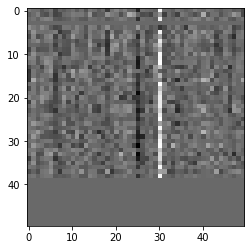

In [4]:
import matplotlib.pyplot as plt

sentence = np.asarray(preprocessor.training_data[1][0], dtype=np.float64)
toxicity = preprocessor.training_data[1][1]
print("Sentence toxicity: ", toxicity)

if toxicity > 0.5:
    print("If a toxic sentence could be an image, this is what it would look like:")
else:
    print("If a nontoxic sentence could be an image, this is what it would look like:")

plt.imshow(sentence, cmap='gray')
plt.show()

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [6]:
class ToxicityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  32,  5)
        self.conv2 = nn.Conv2d(32, 64,  5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(preprocessor.SENTENCE_LENGTH, preprocessor.embedding_dim)
        x = x.view(-1, 1, preprocessor.SENTENCE_LENGTH, preprocessor.embedding_dim)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 1)
    
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#     def __init__(self):
#         super().__init__()
#         self.convs = nn.ModuleList([
#             nn.Conv2d(1, 1, (5, preprocessor.embedding_dim))
#         ])
        
#         x = torch.randn(preprocessor.SENTENCE_LENGTH, preprocessor.embedding_dim)
#         x = x.view(-1, 1, preprocessor.SENTENCE_LENGTH, preprocessor.embedding_dim)
#         self._to_linear = None
#         self.do_convs(x)
        
#         self.fc1 = nn.Linear(self._to_linear, 128)
#         self.fc2 = nn.Linear(128, 1)
    
#     def do_convs(self, x):
#         xs = []
#         for conv in self.convs:
#             x2 = F.relu(conv(x))
#             x2 = torch.squeeze(x2, -1)
#             x2 = F.max_pool1d(x2, x2.size(2))
#             xs.append(x2)
#         x = torch.cat(xs, 2)
        
#         if self._to_linear is None:
#             self._to_linear = xs[len(xs)-1].shape[0]*xs[len(xs)-1].shape[1]*xs[len(xs)-1].shape[2]
        
#         return x
    
#     def forward(self, x):
#         x = self.do_convs(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
    

net = ToxicityNet().to(device)

In [37]:
MODEL_SAVE_PATH = "./cnn-toxicity-model-"+str(preprocessor.SENTENCE_LENGTH)+'x'+str(preprocessor.embedding_dim)+'.pt'

# Load Model from file.
def loadModel(path):
    net.load_state_dict(torch.load(path))
    print("Model loaded!")

# Save Model to file
def saveModel(path):
    torch.save(net.state_dict(), path)
    print("Model saved!")

# Load default
#loadModel(MODEL_SAVE_PATH)
# Load Model 50x50 with like 5 epochs
#loadModel("./cnn-toxicity-model-50x50-backup.pt")

# Save default
saveModel(MODEL_SAVE_PATH)

Model saved!


In [8]:
# Tensor with all the comments
X = torch.Tensor([i[0] for i in preprocessor.training_data]).view(-1, preprocessor.SENTENCE_LENGTH, preprocessor.embedding_dim)
# Tensor with all the comments' toxicity
y = torch.Tensor([i[1] for i in preprocessor.training_data])

EVAL_PCT = 0.10 # percent of training data to use for evaluation
data_size = int(len(X)*EVAL_PCT)

# Split up dataset b/n training and evaluation
# Training data
train_X = X[:-data_size]
train_y = y[:-data_size]
# Evaluation data
eval_X = X[-data_size:]
eval_y = y[-data_size:]


VALID_PCT = 0.5 # percent of evaluation data to use as validation data
test_size = int(len(eval_X)*VALID_PCT)
# Testing data
test_X = eval_X[-test_size:]
test_y = eval_y[-test_size:]
# Validation data
validation_X = eval_X[:-test_size]
validation_y = eval_y[:-test_size]


print("Data loaded in Tensors.")

Data loaded in Tensors.


In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.MSELoss() # Maybe change to to BCELoss?

In [22]:
prev_loss = np.Inf
prev_precision = 0.0
prev_recall = 0.0

prev_loss = 0.07
prev_precision = 0.85
prev_recall = 0.81

In [31]:
BATCH_SIZE = 64
EPOCHS = 2

def train(net):
    global prev_loss
    global prev_precision
    global prev_recall
    
    for epoch in range(EPOCHS):
        for i in range(0, len(train_X), BATCH_SIZE):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,preprocessor.SENTENCE_LENGTH, preprocessor.embedding_dim)
            batch_y = train_y[i:i+BATCH_SIZE]
            
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.train()
            net.zero_grad()
            outputs = net(batch_X).squeeze()
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            # Evaluate
            if i % len(train_X) == 0:
                loss, acc, precision, recall = test(net, validation_X, validation_y)
                if precision >= prev_precision and recall >= prev_recall and loss <= prev_loss:
                    # Save model
                    print("Saving model")
                    saveModel(MODEL_SAVE_PATH)
                    
                    # Update previous values
                    prev_precision = precision
                    prev_recall = recall
                    prev_loss = loss
            

        print(f"Epoch: {epoch+1}. Loss: {loss}\n")

def test(net, data, labels, print_results=True):
    net.eval()
    
    losses = []
    
    correct = 0
    total = 0
    
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    
    with torch.no_grad():
        
        for i in range(len(data)):
            real_toxicity = labels[i].to(device)
            predicted_toxicity = net(data[i].view(-1,1,preprocessor.SENTENCE_LENGTH, preprocessor.embedding_dim).to(device))[0]
            
            loss = loss_function(predicted_toxicity.squeeze(), real_toxicity)
            losses.append(loss.item())
            
            
            if real_toxicity > 0.5:
                if predicted_toxicity > 0.5:
                    true_pos += 1
                else:
                    false_neg += 1
            if real_toxicity <= 0.5:
                if predicted_toxicity <= 0.5:
                    true_neg += 1
                else:
                    false_pos += 1
            
            total += 1
    
    # Calculate average loss
    avg_loss = np.mean(losses)
    
    # Calculate accuracy, precision, recall
    if total != 0:
        accuracy = (true_pos+true_neg)/total
    else:
        total = -1.0
    if true_pos+false_pos != 0:
        precision = true_pos/(true_pos+false_pos)
    else:
        precision = -1.0
    if true_pos+false_neg != 0:
        recall = true_pos/(true_pos+false_neg)
    else:
        recall = -1.0

    if print_results:
        print("Loss: ", round(avg_loss, 5))
        print("Accuracy:", round(accuracy, 3))
        print("Precision:", round(precision, 3))
        print("Recall:", round(recall, 3))
    
    return (avg_loss, accuracy, precision, recall)


In [28]:
test(net, test_X, test_y)

Loss:  0.05476
Accuracy: 0.828
Precision: 0.886
Recall: 0.752


(0.054761742183739984,
 0.8275862068965517,
 0.8857901726427623,
 0.7521142642360459)

In [35]:
train(net)

Loss:  0.05739
Accuracy: 0.833
Precision: 0.883
Recall: 0.768
Epoch: 1. Loss: 0.008272608742117882

Loss:  0.0581
Accuracy: 0.834
Precision: 0.883
Recall: 0.769
Epoch: 2. Loss: 0.0069097536616027355



In [33]:
# Function to convert a sentence to a Tensor that can be fed into the neural network

def sentenceToTensor(sentence):
    unknownWordEmbedding = preprocessor.word2embedding['<UNKNOWN>']
    padWordEmbedding = preprocessor.word2embedding['<PAD>']
    # Loop thru each comment and it's toxicity in the balanced 
    
    # Extract words from sentence
    sent_words = word_tokenize(sentence)
    for wordi in range(preprocessor.SENTENCE_LENGTH):
        if wordi < len(sent_words):
            # Convert word to embedding
            sent_words[wordi] = sent_words[wordi].lower()
            sent_words[wordi] = preprocessor.word2embedding.get(sent_words[wordi], unknownWordEmbedding)
        else:
            # Add padding
            sent_words.append(padWordEmbedding)
    return torch.Tensor(sent_words[:preprocessor.SENTENCE_LENGTH]).view(-1,1,preprocessor.SENTENCE_LENGTH,preprocessor.embedding_dim)

In [36]:
# Testing Cell, have fun.

sentence = []

sentence.append("I hate ice cream.")
sentence.append("I hate pizza.")
sentence.append("I hate you.")

sentence.append("I love you and you're not a loser.")
sentence.append("I love you and you're a loser.")
sentence.append("I love Italians and you're not a loser.")
sentence.append("I hate Italians and you're a loser.")

sentence.append("I hate italian scumbags.")
sentence.append("Die you liberal")
sentence.append("I Love everyone.")
sentence.append("Put a gun to your head and pull the trigger, dude.")
sentence.append("I am gay.")

with torch.no_grad():
    for i in range(len(sentence)):
        sentTensor = sentenceToTensor(sentence[i]).to(device)
        toxicity = net(sentTensor)
        print(sentence[i], )
        if (toxicity > 0.5):
            print(float(toxicity), ", TOXIC")
        else:
            print(float(toxicity), ", Not Toxic.")
        print("\n")

I hate ice cream.
0.17321155965328217 , Not Toxic.


I hate pizza.
0.34952810406684875 , Not Toxic.


I hate you.
-0.08513252437114716 , Not Toxic.


I love you and you're not a loser.
0.263325572013855 , Not Toxic.


I love you and you're a loser.
1.010485291481018 , TOXIC


I love Italians and you're not a loser.
0.18674738705158234 , Not Toxic.


I hate Italians and you're a loser.
0.7630307674407959 , TOXIC


I hate italian scumbags.
1.004913091659546 , TOXIC


Die you liberal
0.8510742783546448 , TOXIC


I Love everyone.
0.07497930526733398 , Not Toxic.


Put a gun to your head and pull the trigger, dude.
0.6512705087661743 , TOXIC


I am gay.
0.49201905727386475 , Not Toxic.


